In [1]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from IPython.display import YouTubeVideo
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

/opt/conda/envs/rapids/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/rapids/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/rapids/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/rapids/lib/python3.7/site-packages/tensorflow/python/framework/dty

## Frame data
Explore one sample tfrecord

In [11]:
frame_lvl_record = "../data/yt8m/2/frame/train/train0001.tfrecord"

In [12]:
vid_ids = []
labels = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):
    tf_example = tf.train.Example.FromString(example)
    vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)

In [13]:
print('Number of videos in this tfrecord: ',len(vid_ids))
print('Picking a youtube video id:',vid_ids[13])

Number of videos in this tfrecord:  1004
Picking a youtube video id: Cbab


Follow link: http://data.yt8m.org/2/j/i/*first2charsOfID*/*FullID*.js
to get actual youtube id

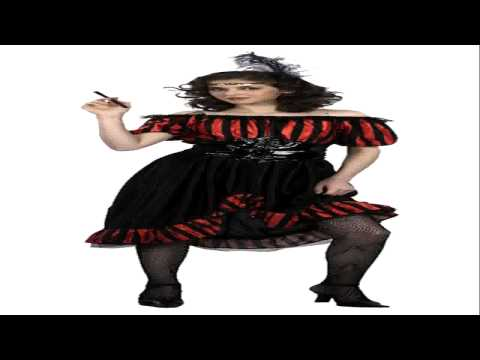

In [14]:
YouTubeVideo('XQ_8wGlS2BU')

Each tfrecord contains ~1000 videos

In [15]:
#Read the first video

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):  
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    
    feat_audio.append(audio_frame)
    feat_rgb.append(rgb_frame)
    break

In [16]:
print('The first video has %d frames' %len(feat_rgb[0]))

The first video has 119 frames


In [96]:
len(feat_rgb[0][0])

1024

## Video Data

In [56]:
video_lvl_record = "../data/yt8m/video/train/train0001.tfrecord"

In [57]:
vvid_ids = []
vlabels = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)
    vvid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    vlabels.append(tf_example.features.feature['labels'].int64_list.value)

In [58]:
print('Number of videos in this tfrecord: ',len(vvid_ids))
print('Picking a youtube video id:',vvid_ids[10])

Number of videos in this tfrecord:  1004
Picking a youtube video id: 80ab


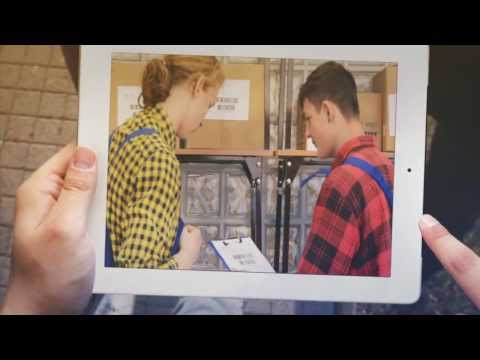

In [59]:
YouTubeVideo('LIGpWlXlAYk')

## Segment Data

In [17]:
validate_record = "../data/yt8m/3/frame/validate/validate0001.tfrecord"
val_vid_ids = []
val_vid_labels = []
segment_start_times = []
segment_end_times = []
segment_labels = []
segment_scores = []

for example in tf.python_io.tf_record_iterator(validate_record):
    tf_example = tf.train.Example.FromString(example)
    val_vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    val_vid_labels.append(tf_example.features.feature['labels'].int64_list.value)
    segment_start_times.append(tf_example.features.feature['segment_start_times'].int64_list.value)
    segment_end_times.append(tf_example.features.feature['segment_end_times'].int64_list.value)
    segment_labels.append(tf_example.features.feature['segment_labels'].int64_list.value)
    segment_scores.append(tf_example.features.feature['segment_scores'].float_list.value)

In [18]:
print(val_vid_ids[0])
print(val_vid_labels[0])
print(segment_start_times[0])
print(segment_end_times[0])
print(segment_labels[0])
print(segment_scores[0])

cpab
[2, 7, 171, 757, 1038, 1158]
[55, 175, 60]
[60, 180, 65]
[1038, 1038, 1038]
[1.0, 1.0, 1.0]


In [19]:
vocab[vocab['Index'] == 1038]

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount
608,1038,/m/0h5xl4x,NaN,115,194


So we are unclear what label is positively ided at 0:55, 2:55, and 1:00... could be a specific car?

Other labels in this video:

Car, Sedan (automobile)

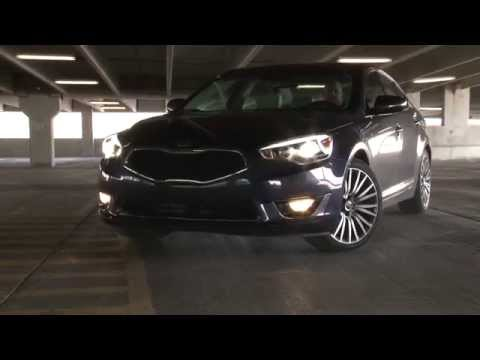

In [20]:
YouTubeVideo('7pRsql_MUi4')

In [21]:
print(val_vid_ids[1])
print(val_vid_labels[1])
print(segment_start_times[1])
print(segment_end_times[1])
print(segment_labels[1])
print(segment_scores[1])

4rab
[11, 20, 22, 29, 32, 112, 303, 397, 472, 477, 528, 560, 572, 2205, 3606]
[30, 45, 125, 95, 115]
[35, 50, 130, 100, 120]
[477, 477, 477, 477, 477]
[0.0, 0.0, 1.0, 0.0, 0.0]


477 = 'Barbecue' (positive id at 2:05-2:10)

Other labels in this video: 

Food, cooking, Dish(food), vegetable, chicken as food, Chicken, Salad, Grilling, Roasting, Sauce, 

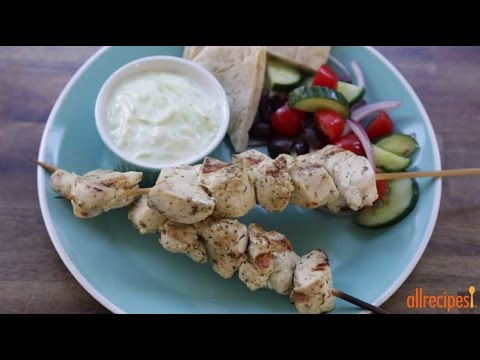

In [22]:
YouTubeVideo("CTiM-_JdMP4")

Questions:
- Do we only get segment labels for one of the video labels?

## Labels

In [23]:
vocab = pd.read_csv('../data/yt8m/vocabulary.csv')

In [24]:
len(vocab['Index'])

1000

In [153]:
vocab.head()

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount
0,3,/m/01jddz,Concert,181,240
1,7,/m/0k4j,Car,159,246
2,8,/m/026bk,Dance,200,245
3,11,/m/02wbm,Food,121,247
4,12,/m/02vx4,Association football,152,249


In [152]:
#vocab[vocab['Index'] == 7]
#vocab[vocab['Index'] == 171]
vocab[vocab['Index'] == 1038]

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount
608,1038,/m/0h5xl4x,NaN,115,194


In [175]:
vocab[vocab['Name'].isnull()]

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount
56,120,/m/0dxrf,NaN,96,243
120,235,/m/0h5y1j0,NaN,74,205
167,316,/m/0h5wtyy,NaN,122,203
253,469,/m/0h5wwjv,NaN,86,177
317,573,/m/03hcy1d,NaN,99,191
430,757,/m/0h5wp8d,NaN,98,217
608,1038,/m/0h5xl4x,NaN,115,194
671,1179,/m/06yzz,NaN,93,223
728,1298,/m/0xmf42g,NaN,104,190
820,1429,/m/0h5wtp0,NaN,76,208


In [181]:
vocab[vocab['Index'] == 22]

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount
9,22,/m/01mtb,Cooking,90,250


In [90]:
n = 4 # although, we'll only show those that appear in the 1,000 for this competition
from collections import Counter

label_mapping =  vocab[['Index', 'Name']].set_index('Index', drop=True).to_dict()['Name']

top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels if x in label_mapping] # filter out the labels that aren't in the 1,000 used for this competition
print(top_n_label_names)

['Concert']


1000 lables are used for the kaggle competition... but there are MORE labels.
Do we want to figure out what these are?

->Don't think they have names...

Text(0.5, 1.0, 'All labels with sample count')

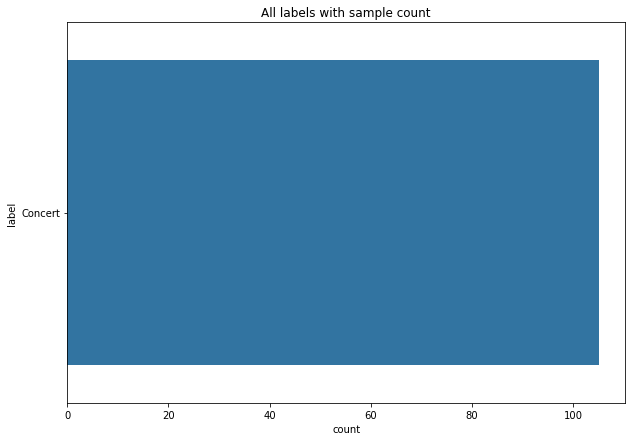

In [91]:
import seaborn as sns
labels_count_dict = dict(top_n)
labels_count_df = pd.DataFrame.from_dict(labels_count_dict, orient='index').reset_index()
labels_count_df.columns = ['label', 'count']
labels_count_df['label'] = labels_count_df['label'].map(label_mapping, na_action='ignore')
TOP_labels = list(labels_count_df['label'])[:n]
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(y='label', x='count', data=labels_count_df)
plt.title('All labels with sample count')

### Labels used in competition

In [65]:
label_mapping =  vocab[['Index', 'Name']].set_index('Index', drop=True).to_dict()['Name']

top_ = Counter([item for sublist in labels for item in sublist]).most_common()
comp_labels = [int(i[0]) for i in top_]
comp_label_names = [label_mapping[x] for x in comp_labels if x in label_mapping]


print(comp_label_names)

['Concert', 'Car', 'Dance', 'Association football', 'Food', 'Pet', 'Mobile phone', 'Motorsport', 'Smartphone', 'Piano', 'Racing', 'Acoustic guitar', 'Drum', 'Motorcycle', 'Train', 'Choir', 'Fishing', 'Motorcycling', 'Drum kit', 'Railroad car', 'Airplane', 'Outdoor recreation', 'Hairstyle', 'Basketball', 'Truck', 'Orchestra', 'Fish', 'Cooking', 'Disc jockey', 'Recreational fishing', 'Wedding', 'Sport utility vehicle', 'Cycling', 'Bicycle', 'IPhone', 'Landing', 'Airport', 'Locomotive', nan, 'Skateboarding', 'Engine', 'Sports car', 'Pickup truck', 'Samsung Galaxy', 'Boxing', 'Playing card', 'Four-wheel drive', 'Doll', 'Dish (food)', 'Festival', 'Skiing', 'Robot', 'Batman', 'Cello', 'Lego', 'Ballet', 'Parade', 'Slam dunk', 'Boat', 'Surfing', 'Helicopter', 'Sasuke Uchiha', 'Train station', 'Jet aircraft', 'Weight training', 'Shoe', 'Batting (cricket)', 'Drawing', 'Comic book', 'Pony', 'Exhaust system', 'Bride', 'Tree', 'Marching band', 'Hunting', 'Cake', 'Jeep', 'Jeep Wrangler', 'Skatepark'

In [82]:
#list of Nan name indices
Nandf = vocab[vocab['Name'].isnull()]
Nan_list = list(Nandf.loc[:,'Index'])
Nan_list

[120, 235, 316, 469, 573, 757, 1038, 1179, 1298, 1429, 1724, 1738]

### Sort By Counts

In [40]:
vocab['PositiveRatio'] = vocab['PositiveSegmentCount']/vocab['TotalSegmentCount']

In [41]:
vocab.head()

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount,PositiveRatio
0,3,/m/01jddz,Concert,181,240,0.754167
1,7,/m/0k4j,Car,159,246,0.646341
2,8,/m/026bk,Dance,200,245,0.816327
3,11,/m/02wbm,Food,121,247,0.489879
4,12,/m/02vx4,Association football,152,249,0.610442


In [42]:
vocab.sort_values(by='PositiveRatio', ascending=False).head()

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount,PositiveRatio
592,1014,/m/0284w,Desert,197,240,0.820833
244,452,/m/02nnq5,Longboard (skateboard),201,245,0.820408
161,305,/m/0r4kr10,Dashcam,200,244,0.819672
19,45,/m/07jdr,Train,200,244,0.819672
44,95,/m/02988_,Four-wheel drive,176,215,0.818605


In [43]:
vocab.sort_values(by='PositiveRatio', ascending=True).head()

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount,PositiveRatio
92,192,/m/02plp2,Xbox 360,25,240,0.104167
129,245,/m/0r4_kmc,PlayStation 4,26,238,0.109244
599,1045,/m/0mjqn,Pie,29,248,0.116935
266,496,/m/0zd6,Macintosh,30,243,0.123457
702,1216,/m/037qhc,Jumbotron,31,249,0.124498


In [44]:
vocab.sort_values(by='PositiveSegmentCount', ascending=False).head()

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount,PositiveRatio
956,1700,/m/02_7fj,Cajón,204,250,0.816000
178,340,/m/08zvcl,Enduro,202,247,0.817814
466,825,/m/01j61q,Tent,202,250,0.808000
198,388,/m/09qqq,Wall,201,248,0.810484
604,1056,/m/03gzqq,Golf club,201,249,0.807229


In [45]:
vocab.sort_values(by='PositiveSegmentCount', ascending=True).head()

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount,PositiveRatio
92,192,/m/02plp2,Xbox 360,25,240,0.104167
129,245,/m/0r4_kmc,PlayStation 4,26,238,0.109244
599,1045,/m/0mjqn,Pie,29,248,0.116935
266,496,/m/0zd6,Macintosh,30,243,0.123457
458,816,/m/015j7,Bible,30,188,0.159574


In [46]:
vocab.sort_values(by='TotalSegmentCount', ascending=False).head()

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount,PositiveRatio
481,862,/m/06mf6,Rabbit,175,250,0.700
45,100,/m/0c4f_,Weight training,112,250,0.448
882,1548,/m/0jtt9,Chili pepper,84,250,0.336
307,560,/m/0dxn2,Roasting,46,250,0.184
89,186,/m/09ct_,Helicopter,190,250,0.760


In [47]:
vocab.sort_values(by='TotalSegmentCount', ascending=True).head()

,Index,KnowledgeGraphId,Name,PositiveSegmentCount,TotalSegmentCount,PositiveRatio
638,1115,/m/042ck,Japanese cuisine,78,155,0.503226
392,706,/m/04r40,Land Rover,82,160,0.512500
102,199,/m/017h86,Action figure,123,162,0.759259
616,1089,/m/0h9627p,Ski-Doo,70,167,0.419162
58,123,/m/0270h,Dessert,44,169,0.260355


In [85]:
print('Not in competition labels')
for i in Nan_list:
    if i not in comp_labels:
        print(i)
        
print('In competition labels')
for i in Nan_list:
    if i in comp_labels:
        print(i)

Not in competition labels
120
573
757
1038
1298
1429
1724
1738
In competition labels
235
316
469
1179


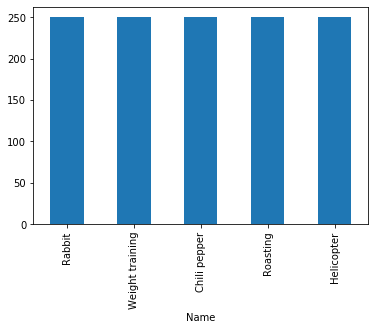

In [95]:
vocab.sort_values(by='TotalSegmentCount', ascending=False).head().plot.bar(x='Name', y='TotalSegmentCount', legend=False)

In [2]:
YouTubeVideo('6bJUbpfnQ')